# Overview

This notebook will be working on House Prices dataset from Kaggle.

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns

In [54]:
train = pd.read_csv("https://github.com/pladee42/house-price-predictions/raw/main/data/train.csv")
test = pd.read_csv("https://github.com/pladee42/house-price-predictions/raw/main/data/test.csv")

train['IsTrain'] = 1
test['IsTrain'] = 0
test['SalePrice'] = np.NaN
all_data = pd.concat([train,test])

## DATA EXPLORATION

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Does the zone impact sale price?

- Yes, it's definitely impact. Looks like FV zone is the most expensive zone, but that of RL zone has wider range of price.

In [56]:
train.groupby(['MSZoning'])['SalePrice'].mean()

MSZoning
C (all)     74528.000000
FV         214014.061538
RH         131558.375000
RL         191004.994787
RM         126316.830275
Name: SalePrice, dtype: float64

<Axes: xlabel='MSZoning', ylabel='SalePrice'>

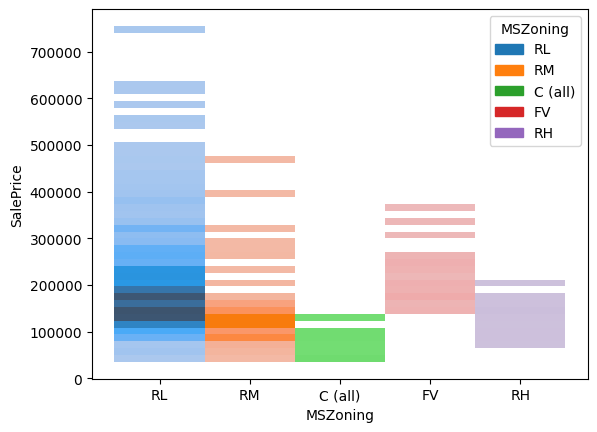

In [57]:
sns.histplot(train, x='MSZoning', y='SalePrice', hue='MSZoning')

Explore House Type

In [58]:
train.groupby(['MSSubClass'])['SalePrice'].mean()

MSSubClass
20     185224.811567
30      95829.724638
40     156125.000000
45     108591.666667
50     143302.972222
60     239948.501672
70     166772.416667
75     192437.500000
80     169736.551724
85     147810.000000
90     133541.076923
120    200779.080460
160    138647.380952
180    102300.000000
190    129613.333333
Name: SalePrice, dtype: float64

Overall Condition

<Axes: xlabel='OverallCond', ylabel='SalePrice'>

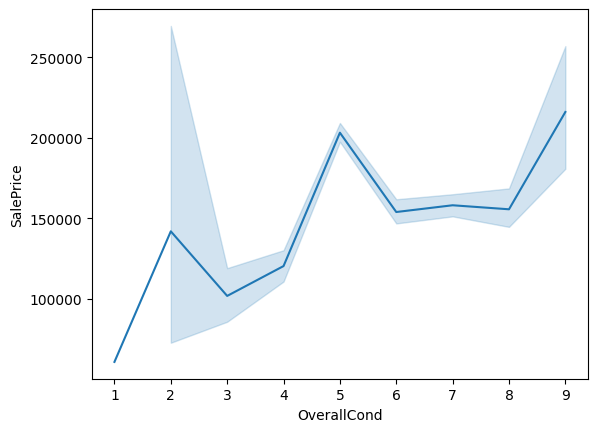

In [59]:
sns.lineplot(train, x='OverallCond', y='SalePrice')

<Axes: xlabel='YrSold', ylabel='SalePrice'>

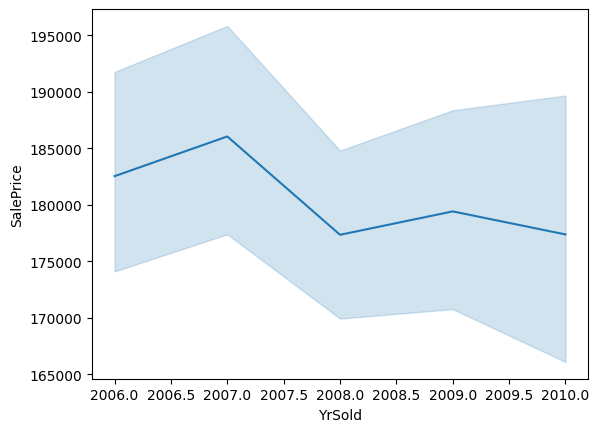

In [60]:
sns.lineplot(train, y='SalePrice',x='YrSold',)

## DATA CLEANING

In [61]:
import duckdb as ddb

In [62]:
# Get the count of null values in each column
null_counts_df = pd.DataFrame(all_data.isnull().sum(), columns=['null_count'])
null_counts_df[null_counts_df['null_count'] > 0]

,null_count
MSZoning,4
LotFrontage,486
Alley,2721
Utilities,2
Exterior1st,1
Exterior2nd,1
MasVnrType,1766
MasVnrArea,23
BsmtQual,81
BsmtCond,82


**Handle Null Values - Alley**
- Treat null values as a category

In [63]:
train["Alley"].value_counts()

Alley
Grvl    50
Pave    41
Name: count, dtype: int64

**Handle Null Values - MasVnrType & MasVnrArea**
- treat null values in MasVnrType column as a category
- If MasVnrType = null, impute MasVnrArea with 0

In [64]:
all_data["MasVnrType"].value_counts()

MasVnrType
BrkFace    879
Stone      249
BrkCmn      25
Name: count, dtype: int64

In [65]:
all_data[all_data["MasVnrType"].isna()]["MasVnrArea"].value_counts()

MasVnrArea
0.0      1735
1.0         3
288.0       1
344.0       1
312.0       1
285.0       1
198.0       1
Name: count, dtype: int64

In [66]:
all_data[all_data["MasVnrArea"].isna()]["MasVnrType"].value_counts()

Series([], Name: count, dtype: int64)

**Handle Null Values - Basement Columns (BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2)**
- If BsmtExposure IS NULL but BsmtQual IS NOT NULL, impute with "No"
- If BsmtFinType2 IS NULL but BsmtQual IS NOT NULL, impute with "Unf"
- treat null values columns as a category

In [67]:
all_data[all_data["BsmtExposure"].isna()][["BsmtQual","BsmtCond","BsmtFinType1","BsmtFinType2"]].value_counts()


BsmtQual  BsmtCond  BsmtFinType1  BsmtFinType2
Gd        TA        Unf           Unf             3
Name: count, dtype: int64

- If BsmtExposure IS NULL but BsmtQual IS NOT NULL, impute with "No"

In [68]:
all_data[(all_data["BsmtFinType1"] == "Unf") & (all_data["BsmtFinType2"] == "Unf")]["BsmtExposure"].value_counts()

BsmtExposure
No    686
Av     83
Mn     57
Gd     22
Name: count, dtype: int64

In [69]:
all_data[all_data["BsmtFinType2"].isna()][["BsmtQual","BsmtCond","BsmtFinType1","BsmtExposure"]].value_counts()


BsmtQual  BsmtCond  BsmtFinType1  BsmtExposure
Gd        TA        GLQ           No              1
Name: count, dtype: int64

- If BsmtFinType2 IS NULL but BsmtQual IS NOT NULL, impute with "Unf"

In [70]:
ddb.execute("""SELECT BsmtFinType2
            FROM all_data
            WHERE BsmtQual = 'Gd' AND BsmtCond = 'TA' AND BsmtFinType1 = 'GLQ' AND BsmtExposure = 'No'
            """).df().value_counts()

BsmtFinType2
Unf             242
ALQ               6
Rec               3
LwQ               2
BLQ               1
Name: count, dtype: int64

In [71]:
all_data[all_data["BsmtFinType1"] == "GLQ"][["BsmtFinType1","BsmtFinType2"]].value_counts()


BsmtFinType1  BsmtFinType2
GLQ           Unf             790
              Rec              19
              LwQ              17
              ALQ              15
              BLQ               7
Name: count, dtype: int64

Check not null values in other Basement columns

In [72]:
ddb.execute("""SELECT BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF
            FROM train
            WHERE BsmtQual IS NULL
            """).df().value_counts()

BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF
0           0           0          0              37
Name: count, dtype: int64

**Handle Null Values - Electrical**
- impute with "SBrkr" (Mode)

In [73]:
#Check Relationship between LotArea and Electrical System
ddb.execute("""SELECT Electrical, COUNT(Electrical), MIN(LotArea), MAX(LotArea), AVG(LotArea), MODE(LotArea)
            FROM all_data
            WHERE Electrical IS NOT NULL
            GROUP BY Electrical
            ORDER BY AVG(LotArea) DESC
            """).df()

,Electrical,count(Electrical),min(LotArea),max(LotArea),avg(LotArea),mode(LotArea)
0,SBrkr,2671,1300,215245,10260.784350,9600
1,FuseA,188,3500,31250,9326.367021,9000
2,Mix,1,8967,8967,8967.000000,8967
3,FuseF,50,4480,21780,8785.820000,7200
4,FuseP,8,4761,10914,7852.500000,6040


In [74]:
#Check Relationship between LotArea and House Price
ddb.execute("""SELECT Electrical, COUNT(Electrical), MIN(SalePrice), MAX(SalePrice), AVG(SalePrice), MODE(SalePrice)
            FROM all_data
            WHERE Electrical IS NOT NULL
            GROUP BY Electrical
            ORDER BY AVG(SalePrice) DESC
            """).df()

,Electrical,count(Electrical),min(SalePrice),max(SalePrice),avg(SalePrice),mode(SalePrice)
0,SBrkr,2671,37900.0,755000.0,186825.113193,140000.0
1,FuseA,188,34900.0,239000.0,122196.893617,115000.0
2,FuseF,50,39300.0,169500.0,107675.444444,129900.0
3,FuseP,8,73000.0,137000.0,97333.333333,82000.0
4,Mix,1,67000.0,67000.0,67000.000000,67000.0


In [75]:
all_data[all_data["Electrical"].isna()][["LotArea"]]


,LotArea
1379,9735


**Data Cleaning & Exploratory Summary**

1. If MasVnrType = null, impute MasVnrArea with 0
2. If BsmtExposure IS NULL but BsmtQual IS NOT NULL, impute with "No"
3. If BsmtFinType2 IS NULL but BsmtQual IS NOT NULL, impute with "Unf"
4. Impute with 0 --> ["LotFrontage","MasVnrArea", "GarageCars", "GarageArea"]
5. Impute with MODE --> Electrical
6. Treat Yearly columns as Age --> GarageYrBlt (Impute null with 99)
7. Treat null as a category --> ["Alley","MasVnrType","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2", "FireplaceQu","GarageType"]


## DATA PRE-PROCESSING

In [76]:
preprocessed = all_data.copy()

In [77]:
# 1. If MasVnrType = null, impute MasVnrArea with 0
preprocessed.loc[(preprocessed["MasVnrType"].isna()) & (preprocessed["MasVnrArea"] > 0), "MasVnrArea"] = 0
# 2. If BsmtExposure IS NULL but BsmtQual IS NOT NULL, impute with "No"
preprocessed.loc[(preprocessed["BsmtExposure"].isna()) & (preprocessed["BsmtQual"].isna() == False), "BsmtExposure"] = "No"
# 3. If BsmtFinType2 IS NULL but BsmtQual IS NOT NULL, impute with "Unf"
preprocessed.loc[(preprocessed["BsmtFinType2"].isna()) & (preprocessed["BsmtQual"].isna() == False), "BsmtFinType2"] = "Unf"

In [78]:
preprocessed[(preprocessed["BsmtFinType2"].isna()) & (preprocessed["BsmtQual"].isna() == False)]["BsmtQual"]

Series([], Name: BsmtQual, dtype: object)

In [79]:
# 4. Impute with 0 --> ["LotFrontage","MasVnrArea", "GarageCars", "GarageArea"]

preprocessed[["LotFrontage","MasVnrArea", "GarageCars", "GarageArea"]] = preprocessed[["LotFrontage","MasVnrArea", "GarageCars", "GarageArea"]].fillna(0)

In [80]:
# 5. Impute with MODE --> Electrical
preprocessed["Electrical"] = preprocessed["Electrical"].fillna("SBrkr")

Yearly Columns Pre-processing (Convert to Age)

In [81]:
yearly_columns = ["YearBuilt", "YearRemodAdd", "GarageYrBlt"]
preprocessed[yearly_columns]

,YearBuilt,YearRemodAdd,GarageYrBlt
0,2003,2003,2003.0
1,1976,1976,1976.0
2,2001,2002,2001.0
3,1915,1970,1998.0
4,2000,2000,2000.0
...,...,...,...
1454,1970,1970,NaN
1455,1970,1970,1970.0
1456,1960,1996,1960.0
1457,1992,1992,NaN


In [82]:
preprocessed[["AgeBuilt", "AgeRemodAdd", "AgeGarageYrBlt"]] = preprocessed[yearly_columns].applymap(lambda x: 2024 - x if not pd.isna(x) else 999)
preprocessed.drop(yearly_columns,axis=1,inplace=True)

/var/folders/tx/6718jl_937qg03h108680hc00000gn/T/ipykernel_46382/2191661123.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  preprocessed[["AgeBuilt", "AgeRemodAdd", "AgeGarageYrBlt"]] = preprocessed[yearly_columns].applymap(lambda x: 2024 - x if not pd.isna(x) else 999)


In [83]:
pd.DataFrame(preprocessed.isnull().sum(), columns=['null_count'])[pd.DataFrame(preprocessed.isnull().sum(), columns=['null_count'])['null_count'] > 0]

,null_count
MSZoning,4
Alley,2721
Utilities,2
Exterior1st,1
Exterior2nd,1
MasVnrType,1766
BsmtQual,81
BsmtCond,82
BsmtExposure,79
BsmtFinType1,79


In [84]:
#Calculate the number of month that the house were sold
def calculate_ageSold(row):
    current_year = 2024
    current_month = 6
    year_diff = current_year - row["YrSold"]
    month_diff = current_month - row["MoSold"]
    # If month difference is negative, subtract one year and add 12 months to month difference
    if month_diff < 0:
        year_diff -= 1
        month_diff += 12
    # Combine year and month difference to get age in years
    age = year_diff + month_diff / 12
    return age

preprocessed["AgeSold"] = preprocessed[["YrSold", "MoSold"]].apply(calculate_ageSold,axis=1)
preprocessed.drop(["YrSold", "MoSold"],axis=1, inplace=True)

**General Preprocessing**

In [85]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn import metrics


In [86]:
preprocessed.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPor

In [87]:
categorical_columns = preprocessed.select_dtypes(include=['object', 'category']).columns
numerical_columns = preprocessed.select_dtypes(include=['int64', 'float64']).columns

#MSSubClass is a categorical column but dtype is int64
numerical_columns = numerical_columns.drop(['SalePrice', 'MSSubClass', 'Id', 'IsTrain'])
categorical_columns = categorical_columns.append(pd.Index(["MSSubClass"]))

Imputation

In [88]:
X_train_pre = preprocessed[preprocessed["IsTrain"] == 1]
X_test_pre = preprocessed[preprocessed["IsTrain"] == 0]

In [89]:
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')

train_num_imputed = pd.DataFrame(num_imputer.fit_transform(X_train_pre[numerical_columns]),columns=numerical_columns)
test_num_imputed = pd.DataFrame(num_imputer.transform(X_test_pre[numerical_columns]),columns=numerical_columns)
train_cat_imputed = pd.DataFrame(cat_imputer.fit_transform(X_train_pre[categorical_columns]),columns=categorical_columns)
test_cat_imputed = pd.DataFrame(cat_imputer.transform(X_test_pre[categorical_columns]),columns=categorical_columns)

X_train_imputed = pd.concat([train_num_imputed, train_cat_imputed],axis=1)
X_test_imputed = pd.concat([test_num_imputed, test_cat_imputed],axis=1)
X_train_imputed

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass
0,65.0,8450.0,7.0,5.0,196.0,706.0,0.0,150.0,856.0,856.0,...,RFn,TA,TA,Y,missing,missing,missing,WD,Normal,60
1,80.0,9600.0,6.0,8.0,0.0,978.0,0.0,284.0,1262.0,1262.0,...,RFn,TA,TA,Y,missing,missing,missing,WD,Normal,20
2,68.0,11250.0,7.0,5.0,162.0,486.0,0.0,434.0,920.0,920.0,...,RFn,TA,TA,Y,missing,missing,missing,WD,Normal,60
3,60.0,9550.0,7.0,5.0,0.0,216.0,0.0,540.0,756.0,961.0,...,Unf,TA,TA,Y,missing,missing,missing,WD,Abnorml,70
4,84.0,14260.0,8.0,5.0,350.0,655.0,0.0,490.0,1145.0,1145.0,...,RFn,TA,TA,Y,missing,missing,missing,WD,Normal,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917.0,6.0,5.0,0.0,0.0,0.0,953.0,953.0,953.0,...,RFn,TA,TA,Y,missing,missing,missing,WD,Normal,60
1456,85.0,13175.0,6.0,6.0,119.0,790.0,163.0,589.0,1542.0,2073.0,...,Unf,TA,TA,Y,missing,MnPrv,missing,WD,Normal,20
1457,66.0,9042.0,7.0,9.0,0.0,275.0,0.0,877.0,1152.0,1188.0,...,RFn,TA,TA,Y,missing,GdPrv,Shed,WD,Normal,70
1458,68.0,9717.0,5.0,6.0,0.0,49.0,1029.0,0.0,1078.0,1078.0,...,Unf,TA,TA,Y,missing,missing,missing,WD,Normal,20


Normalization

In [90]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed[numerical_columns]),columns=numerical_columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed[numerical_columns]),columns=numerical_columns)
X_train_scaled

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,AgeBuilt,AgeRemodAdd,AgeGarageYrBlt,AgeSold
0,0.212877,-0.207142,0.651479,-0.517200,0.518257,0.575425,-0.288653,-0.944591,-0.459303,-0.793434,...,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.050994,-0.878668,-0.352456,0.133891
1,0.645747,-0.091886,-0.071836,2.179628,-0.567784,1.171992,-0.288653,-0.641228,0.466465,0.257140,...,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.156734,0.429577,-0.229496,0.704732
2,0.299451,0.073480,0.651479,-0.517200,0.329862,0.092907,-0.288653,-0.301643,-0.313369,-0.627826,...,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.984752,-0.830215,-0.343348,-0.310096
3,0.068587,-0.096897,0.651479,-0.517200,-0.567784,-0.499274,-0.288653,-0.061670,-0.687324,-0.521734,...,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,1.863632,0.720298,-0.329685,1.656132
4,0.761179,0.375148,1.374795,-0.517200,1.371575,0.463568,-0.288653,-0.174865,0.199680,-0.045611,...,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.951632,-0.733308,-0.338793,-0.500376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.126303,-0.260560,-0.071836,-0.517200,-0.567784,-0.973018,-0.288653,0.873321,-0.238122,-0.542435,...,-0.100558,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.918511,-0.733308,-0.334239,0.514451
1456,0.790037,0.266407,-0.071836,0.381743,0.091598,0.759659,0.722112,0.049262,1.104925,2.355701,...,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.222975,-0.151865,-0.238604,-1.388350
1457,0.241735,-0.147810,0.651479,3.078570,-0.567784,-0.369871,-0.288653,0.701265,0.215641,0.065656,...,0.201405,-0.359325,-0.116339,-0.270208,-0.068692,4.953112,1.002492,-1.024029,-0.070104,-1.578630
1458,0.299451,-0.080160,-0.795151,0.381743,-0.567784,-0.865548,6.092188,-1.284176,0.046905,-0.218982,...,-0.704483,1.473789,-0.116339,-0.270208,-0.068692,-0.087688,0.704406,-0.539493,-0.111091,-1.515203


One Hot Encode

In [91]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
train_encoded = ohe.fit_transform(X_train_imputed[categorical_columns])
test_encoded = ohe.transform(X_test_imputed[categorical_columns])

# put the features into a dataframe and join with the original
encoded_columns=list()
for col, values in zip(categorical_columns.to_list(), ohe.categories_):
    encoded_columns.extend([col + '_' + str(value) for value in values])
encoded_columns

X_train_encoded = pd.DataFrame(train_encoded, columns=encoded_columns)
X_test_encoded = pd.DataFrame(test_encoded, columns=encoded_columns)
X_train_encoded

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_missing,...,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
from IPython.display import display, HTML
# Function to create scrollable table within a small window
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

In [93]:
#Combine processed data
X_train_pre = pd.concat([X_train_scaled, X_train_encoded], axis=1)
X_test_pre = pd.concat([X_test_scaled, X_test_encoded], axis=1)
display(HTML(create_scrollable_table(pd.DataFrame({'col':X_train_pre.columns.to_list()}),table_id='dimensions', title='Column List')))

,col
0,LotFrontage
1,LotArea
2,OverallQual
3,OverallCond
4,MasVnrArea
5,BsmtFinSF1
6,BsmtFinSF2
7,BsmtUnfSF
8,TotalBsmtSF
9,1stFlrSF


Reduce Dimension - PCA

In [94]:
pca = PCA().fit(X_train_pre)
# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Choose the number of components based on the explained variance threshold
n_components = np.argmax(cumulative_explained_variance >= 0.94) + 1

pca = PCA(n_components=n_components)
X = pca.fit_transform(X_train_pre)
X_test = pca.transform(X_test_pre)
X.shape

(1460, 74)

## ML MODEL

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

In [96]:
y = np.log(preprocessed[preprocessed["IsTrain"] == 1]["SalePrice"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=101)

In [102]:
tf.random.set_seed(101)

def deep_learning_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(74, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(74 // 2, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(74 // 4, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

dl_wrapper = KerasRegressor(
    model=deep_learning_model,
    epochs=200,
    verbose=2,
    callbacks=[early_stopping]
)


In [103]:

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=101),
    'XGBoost': XGBRegressor(random_state=101),
    'Deep Learning': dl_wrapper
    }

param_grids = {
    'LinearRegression': {},
    'RandomForest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 30],
        'min_samples_split': [2, 5, 10],
    },
    'XGBoost': {
        'n_estimators': [250, 500, 750],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 6, 10],
    },
    'Deep Learning': {
        'model__optimizer': ['adam', 'sgd', 'rmsprop'],
        'batch_size': [32, 64, 128],
    }
}

cv = KFold(n_splits=3, shuffle=True, random_state=101)

grids = {}
for model_name, model in models.items():
    grids[model_name] = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
    grids[model_name].fit(X_train, y_train)
    best_params = grids[model_name].best_params_
    best_score = grids[model_name].best_score_
    
    print(f'Best parameters for {model_name}: {best_params}')
    print(f'Best Score for {model_name}: {best_score}\n')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
Best parameters for LinearRegression: {}
Best Score for LinearRegression: -0.017818828811878833

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersi

[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: Inconsi

[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   5.8s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: Inconsi

[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   6.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   5.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   5.5s
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: Inconsi

[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=   2.7s
[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: Inconsi

[CV] END max_depth=None, min_samples_split=2, n_estimators=500; total time=  14.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=500; total time=  14.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: Inconsi

[CV] END max_depth=None, min_samples_split=10, n_estimators=100; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=None, min_samples_split=2, n_estimators=500; total time=  14.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   4.6s
[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   4.6s
[CV] END max_depth=None, min_samples_split=10, n_estimators=200; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: Inconsi

[CV] END max_depth=None, min_samples_split=5, n_estimators=500; total time=  13.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END max_depth=None, min_samples_split=5, n_estimators=500; total time=  13.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: Inconsi

[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=None, min_samples_split=5, n_estimators=500; total time=  13.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   5.1s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: Inconsi

[CV] END max_depth=None, min_samples_split=10, n_estimators=500; total time=  12.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   2.4s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: Inconsi

[CV] END max_depth=None, min_samples_split=10, n_estimators=500; total time=  12.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=None, min_samples_split=10, n_estimators=500; total time=  12.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   5.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   5.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=5, n_estimators=200; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=2, n_estimators=500; total time=  13.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   2.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=500; total time=  12.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: Inconsi

[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   2.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=2, n_estimators=500; total time=  12.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   4.7s
[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: Inconsi

[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   4.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=5, n_estimators=500; total time=  12.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=5, n_estimators=500; total time=  12.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_split=2, n_estimators=100; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_split=2, n_estimators=100; total time=   2.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_split=2, n_estimators=100; total time=   2.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=5, n_estimators=500; total time=  12.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=10, min_samples_split=10, n_estimators=500; total time=  11.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_split=2, n_estimators=200; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_split=2, n_estimators=200; total time=   5.9s
[CV] END max_depth=30, min_samples_split=2, n_estimators=200; total time=   5.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: Inconsi

[CV] END max_depth=10, min_samples_split=10, n_estimators=500; total time=  11.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_split=5, n_estimators=100; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END max_depth=30, min_samples_split=5, n_estimators=100; total time=   2.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: Inconsi

[CV] END max_depth=10, min_samples_split=10, n_estimators=500; total time=  11.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_split=5, n_estimators=200; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_split=5, n_estimators=200; total time=   5.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_split=5, n_estimators=200; total time=   5.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   2.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   2.4s
[CV] END max_depth=30, min_samples_split=2, n_estimators=500; total time=  14.8s
[CV] END max_depth=30, min_samples_split=2, n_estimators=500; total time=  14.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: Inconsi

[CV] END max_depth=30, min_samples_split=10, n_estimators=100; total time=   2.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_split=2, n_estimators=500; total time=  14.1s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_split=10, n_estimators=200; total time=   4.9s
[CV] END max_depth=30, min_samples_split=10, n_estimators=200; total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[CV] END max_depth=30, min_samples_split=10, n_estimators=200; total time=   5.1s
[CV] END max_depth=30, min_samples_split=5, n_estimators=500; total time=  13.2s
[CV] END max_depth=30, min_samples_split=5, n_estimators=500; total time=  13.2s
[CV] END max_depth=30, min_samples_split=5, n_estimators=500; total time=  12.6s
[CV] END max_depth=30, min_samples_split=10, n_estimators=500; total time=   9.9s
[CV] END max_depth=30, min_samples_split=10, n_estimators=500; total time=   9.5s
[CV] END max_depth=30, min_samples_split=10, n_estimators=500; total time=   8.9s
Best parameters for RandomForest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 500}
Best Score for RandomForest: -0.020567903170265772

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=250; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=250; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimator

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=750; total time=   2.9s
[CV] END ...learning_rate=0.1, max_depth=6, n_estimators=750; total time=   3.1s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=250; total time=   4.4s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=250; total time=   4.2s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=250; total time=   4.4s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=500; total time=   4.7s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=500; total time=   4.4s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=500; total time=   4.6s
[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=250; total time=   0.6s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=750; total time=   4.5s
[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=250; total time=   0.6s
[CV] END ...learning_rate=0.3, max_depth=3, n_estimators=250; total time=   0.6s
[CV] END ...learning_rate=0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object 

[CV] END ................batch_size=64, model__optimizer=sgd; total time=   0.0s
[CV] END ............batch_size=64, model__optimizer=rmsprop; total time=   0.0s
[CV] END ............batch_size=64, model__optimizer=rmsprop; total time=   0.0s
[CV] END ............batch_size=64, model__optimizer=rmsprop; total time=   0.0s
[CV] END ..............batch_size=128, model__optimizer=adam; total time=   0.0s
[CV] END ..............batch_size=128, model__optimizer=adam; total time=   0.0s
[CV] END ..............batch_size=128, model__optimizer=adam; total time=   0.1s
[CV] END ...............batch_size=128, model__optimizer=sgd; total time=   0.0s
[CV] END ...........batch_size=128, model__optimizer=rmsprop; total time=   0.0s
[CV] END ...............batch_size=128, model__optimizer=sgd; total time=   0.0s
[CV] END ...............batch_size=128, model__optimizer=sgd; total time=   0.1s
[CV] END ...........batch_size=128, model__optimizer=rmsprop; total time=   0.0s
[CV] END ...........batch_si

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object 

Epoch 1/200
25/25 - 0s - 7ms/step - loss: 44.3013
Epoch 2/200
25/25 - 0s - 696us/step - loss: 9.1483
Epoch 3/200


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


25/25 - 0s - 647us/step - loss: 4.7279
Epoch 4/200
25/25 - 0s - 852us/step - loss: 3.7142
Epoch 5/200
25/25 - 0s - 626us/step - loss: 3.7424
Epoch 6/200
25/25 - 0s - 605us/step - loss: 2.7284
Epoch 7/200
25/25 - 0s - 585us/step - loss: 2.7209
Epoch 8/200
25/25 - 0s - 603us/step - loss: 2.4158
Epoch 9/200
25/25 - 0s - 588us/step - loss: 2.0396
Epoch 10/200
25/25 - 0s - 615us/step - loss: 2.1415
Epoch 11/200
25/25 - 0s - 602us/step - loss: 1.9352
Epoch 12/200
25/25 - 0s - 592us/step - loss: 1.8522
Epoch 13/200
25/25 - 0s - 584us/step - loss: 1.8852
Epoch 14/200
25/25 - 0s - 599us/step - loss: 1.7706
Epoch 15/200
25/25 - 0s - 747us/step - loss: 1.6119
Epoch 16/200
25/25 - 0s - 666us/step - loss: 1.5219
Epoch 17/200
25/25 - 0s - 781us/step - loss: 1.5346
Epoch 18/200
25/25 - 0s - 635us/step - loss: 1.5548
Epoch 19/200
25/25 - 0s - 612us/step - loss: 1.4495
Epoch 20/200
25/25 - 0s - 610us/step - loss: 1.3655
Epoch 21/200
25/25 - 0s - 606us/step - loss: 1.4076
Epoch 22/200
25/25 - 0s - 602us

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
26 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scike

Epoch 1/200
37/37 - 1s - 14ms/step - loss: 129.5123
Epoch 2/200
37/37 - 0s - 642us/step - loss: 52.6827
Epoch 3/200
37/37 - 0s - 631us/step - loss: 18.2828
Epoch 4/200
37/37 - 0s - 632us/step - loss: 13.4290
Epoch 5/200
37/37 - 0s - 613us/step - loss: 11.8562
Epoch 6/200
37/37 - 0s - 643us/step - loss: 11.3655
Epoch 7/200
37/37 - 0s - 611us/step - loss: 10.8192
Epoch 8/200
37/37 - 0s - 626us/step - loss: 9.6796
Epoch 9/200
37/37 - 0s - 610us/step - loss: 9.5957
Epoch 10/200


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


37/37 - 0s - 2ms/step - loss: 8.9685
Epoch 11/200
37/37 - 0s - 659us/step - loss: 8.7733
Epoch 12/200
37/37 - 0s - 633us/step - loss: 8.9229
Epoch 13/200
37/37 - 0s - 627us/step - loss: 8.4499
Epoch 14/200
37/37 - 0s - 625us/step - loss: 7.9625
Epoch 15/200
37/37 - 0s - 624us/step - loss: 7.9123
Epoch 16/200
37/37 - 0s - 627us/step - loss: 7.7921
Epoch 17/200
37/37 - 0s - 618us/step - loss: 8.0675
Epoch 18/200
37/37 - 0s - 644us/step - loss: 7.4512
Epoch 19/200
37/37 - 0s - 877us/step - loss: 7.4268
Epoch 20/200
37/37 - 0s - 640us/step - loss: 8.4383
Epoch 21/200
37/37 - 0s - 627us/step - loss: 7.1341
Epoch 22/200
37/37 - 0s - 615us/step - loss: 7.1772
Epoch 23/200
37/37 - 0s - 649us/step - loss: 7.3522
Epoch 24/200
37/37 - 0s - 622us/step - loss: 7.5003
Epoch 25/200
37/37 - 0s - 665us/step - loss: 7.2805
Epoch 26/200
37/37 - 0s - 601us/step - loss: 6.5160
Epoch 27/200
37/37 - 0s - 580us/step - loss: 7.5503
Epoch 28/200
37/37 - 0s - 587us/step - loss: 6.8152
Epoch 29/200
37/37 - 0s - 6

## EVALUATION

In [104]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Linear Regression

In [105]:
y_pred = grids['LinearRegression'].predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

R-squared (R²): 0.7711
Mean Squared Error (MSE): 0.0404
Mean Absolute Error (MAE): 0.1009
Root Mean Squared Error (RMSE): 0.2010


Random Forest

In [106]:
y_pred = grids['RandomForest'].predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

R-squared (R²): 0.8430
Mean Squared Error (MSE): 0.0277
Mean Absolute Error (MAE): 0.1069
Root Mean Squared Error (RMSE): 0.1665


Deep Learning

In [108]:
y_pred = grids['Deep Learning'].predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

10/10 - 0s - 4ms/step
R-squared (R²): 0.6751
Mean Squared Error (MSE): 0.0574
Mean Absolute Error (MAE): 0.1746
Root Mean Squared Error (RMSE): 0.2395


**Best Result: XGBoost**

R-squared (R²): 0.8584

Mean Squared Error (MSE): 0.0250

Mean Absolute Error (MAE): 0.1006

Root Mean Squared Error (RMSE): 0.1581

In [107]:
y_pred = grids['XGBoost'].predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

R-squared (R²): 0.8584
Mean Squared Error (MSE): 0.0250
Mean Absolute Error (MAE): 0.1006
Root Mean Squared Error (RMSE): 0.1581


## SUBMISSION

In [109]:
result = np.e**(grids['XGBoost'].predict(X_test))

In [111]:
file_submit = pd.concat([test['Id'],
                         pd.DataFrame({'SalePrice': result})],axis=1)

file_submit.to_csv("submission.csv",index=False)